In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
import matplotlib.pyplot as plt
import glob
import cv2
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import albumentations
import argparse
#import models

from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from torchvision.utils import save_image
from sklearn.model_selection import train_test_split

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 128, kernel_size=5, padding=1)
        self.conv2 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 3, kernel_size=1, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        return x

class SimpleAE(nn.Module):
    def __init__(self):
        super(SimpleAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5),
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=5),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=5),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, kernel_size=5),
            nn.ReLU(True))
    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [5]:
# constructing the argument parser
#parser = argparse.ArgumentParser()
#parser.add_argument('-e', '--epochs', type=int, default=50,
            #help='number of epochs to train the model for')
#args = vars(parser.parse_args())

# helper functions
image_dir = 'drive/My Drive/Image-Deblurring/outputs/saved_images'
os.makedirs(image_dir, exist_ok=True)

def save_decoded_image(img, name):
    img = img.view(img.size(0), 3, 224, 224)
    save_image(img, name)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)


cuda


In [6]:

batch_size = 2

gauss_blur = os.listdir('drive/My Drive/Image-Deblurring/input/gaussian_blurred/')
gauss_blur.sort()
sharp = os.listdir('drive/My Drive/Image-Deblurring/input/sharp/')
sharp.sort()

x_blur = []
for i in range(len(gauss_blur)):
    x_blur.append(gauss_blur[i])

y_sharp = []
for i in range(len(sharp)):
    y_sharp.append(sharp[i])

print(x_blur[10])
print(y_sharp[10])

# For the original dataset:
# # Split the data into training and temporary sets
# x_train_temp, x_test, y_train_temp, y_test = train_test_split(x_blur, y_sharp, test_size=0.2, random_state=42)
# # Split the temporary set into training and validation sets
# x_train, x_val, y_train, y_val = train_test_split(x_train_temp, y_train_temp, test_size=0.25, random_state=42)
# print("Training set length:", len(x_train))
# print("Validation set length:", len(x_val))
# print("Test set length:", len(x_test))

(x_train, x_val, y_train, y_val) = train_test_split(x_blur, y_sharp, test_size=0.25)

print(len(x_train))
print(len(x_val))


109_HONOR-7X_S.jpg
109_HONOR-7X_S.jpg
Training set length: 210
Validation set length: 70
Test set length: 70


In [8]:
# define transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

class DeblurDataset(Dataset):
    def __init__(self, blur_paths, sharp_paths=None, transforms=None):
        self.X = blur_paths
        self.y = sharp_paths
        self.transforms = transforms

    def __len__(self):
        return (len(self.X))

    def __getitem__(self, i):
        blur_image = cv2.imread(f"drive/My Drive/Image-Deblurring/input/gaussian_blurred/{self.X[i]}")

        if self.transforms:
            blur_image = self.transforms(blur_image)

        if self.y is not None:
            sharp_image = cv2.imread(f"drive/My Drive/Image-Deblurring/input/sharp/{self.y[i]}")
            sharp_image = self.transforms(sharp_image)
            return (blur_image, sharp_image)
        else:
            return blur_image

train_data = DeblurDataset(x_train, y_train, transform)
val_data = DeblurDataset(x_val, y_val, transform)

trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

model = CNN().to(device)
print(model)

# the loss function
criterion = nn.MSELoss()
# the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        patience=5,
        factor=0.1,
        verbose=True
    )

def fit(model, dataloader, epoch):
    model.train()
    running_loss = 0.0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        blur_image = data[0]
        sharp_image = data[1]
        blur_image = blur_image.to(device)
        sharp_image = sharp_image.to(device)
        optimizer.zero_grad()
        outputs = model(blur_image)
        loss = criterion(outputs, sharp_image)
        # backpropagation
        loss.backward()
        # update the parameters
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss/len(dataloader.dataset)
    print(f"Train Loss: {train_loss:.5f}")

    return train_loss

# the training function
def validate(model, dataloader, epoch):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            blur_image = data[0]
            sharp_image = data[1]
            blur_image = blur_image.to(device)
            sharp_image = sharp_image.to(device)
            outputs = model(blur_image)
            loss = criterion(outputs, sharp_image)
            running_loss += loss.item()

            if epoch == 0 and i == (len(val_data)/dataloader.batch_size)-1:
                save_decoded_image(sharp_image.cpu().data, name=f"drive/My Drive/Image-Deblurring/outputs/saved_images/sharp{epoch}.jpg")
                save_decoded_image(blur_image.cpu().data, name=f"drive/My Drive/Image-Deblurring/outputs/saved_images/blur{epoch}.jpg")

        val_loss = running_loss/len(dataloader.dataset)
        print(f"Val Loss: {val_loss:.5f}")

        save_decoded_image(outputs.cpu().data, name=f"drive/My Drive/Image-Deblurring/outputs/saved_images/val_deblurred{epoch}.jpg")

        return val_loss

CNN(
  (conv1): Conv2d(3, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 3, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
)


In [9]:
print(model)
print(optimizer)

CNN(
  (conv1): Conv2d(3, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 3, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


Epoch 1 of 25


100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Train Loss: 0.04515


100%|██████████| 35/35 [00:46<00:00,  1.33s/it]


Val Loss: 0.04415
Epoch 2 of 25


100%|██████████| 105/105 [00:36<00:00,  2.86it/s]


Train Loss: 0.03089


100%|██████████| 35/35 [00:10<00:00,  3.30it/s]


Val Loss: 0.00325
Epoch 3 of 25


100%|██████████| 105/105 [00:35<00:00,  2.97it/s]


Train Loss: 0.00285


100%|██████████| 35/35 [00:11<00:00,  3.10it/s]


Val Loss: 0.00234
Epoch 4 of 25


100%|██████████| 105/105 [00:34<00:00,  3.00it/s]


Train Loss: 0.00252


100%|██████████| 35/35 [00:10<00:00,  3.28it/s]


Val Loss: 0.00224
Epoch 5 of 25


100%|██████████| 105/105 [00:35<00:00,  2.94it/s]


Train Loss: 0.00234


100%|██████████| 35/35 [00:11<00:00,  3.15it/s]


Val Loss: 0.00211
Epoch 6 of 25


100%|██████████| 105/105 [00:34<00:00,  3.08it/s]


Train Loss: 0.00222


100%|██████████| 35/35 [00:11<00:00,  3.17it/s]


Val Loss: 0.00237
Epoch 7 of 25


100%|██████████| 105/105 [00:35<00:00,  2.97it/s]


Train Loss: 0.00241


100%|██████████| 35/35 [00:11<00:00,  3.18it/s]


Val Loss: 0.00197
Epoch 8 of 25


100%|██████████| 105/105 [00:34<00:00,  3.06it/s]


Train Loss: 0.00207


100%|██████████| 35/35 [00:11<00:00,  3.15it/s]


Val Loss: 0.00190
Epoch 9 of 25


100%|██████████| 105/105 [00:35<00:00,  2.96it/s]


Train Loss: 0.00198


100%|██████████| 35/35 [00:10<00:00,  3.40it/s]


Val Loss: 0.00180
Epoch 10 of 25


100%|██████████| 105/105 [00:35<00:00,  2.99it/s]


Train Loss: 0.00188


100%|██████████| 35/35 [00:11<00:00,  3.12it/s]


Val Loss: 0.00172
Epoch 11 of 25


100%|██████████| 105/105 [00:35<00:00,  2.97it/s]


Train Loss: 0.00181


100%|██████████| 35/35 [00:09<00:00,  3.56it/s]


Val Loss: 0.00166
Epoch 12 of 25


100%|██████████| 105/105 [00:35<00:00,  2.97it/s]


Train Loss: 0.00192


100%|██████████| 35/35 [00:11<00:00,  3.15it/s]


Val Loss: 0.00162
Epoch 13 of 25


100%|██████████| 105/105 [00:34<00:00,  3.06it/s]


Train Loss: 0.00171


100%|██████████| 35/35 [00:10<00:00,  3.24it/s]


Val Loss: 0.00158
Epoch 14 of 25


100%|██████████| 105/105 [00:35<00:00,  3.00it/s]


Train Loss: 0.00213


100%|██████████| 35/35 [00:11<00:00,  3.18it/s]


Val Loss: 0.00176
Epoch 15 of 25


100%|██████████| 105/105 [00:34<00:00,  3.09it/s]


Train Loss: 0.00173


100%|██████████| 35/35 [00:11<00:00,  3.16it/s]


Val Loss: 0.00160
Epoch 16 of 25


100%|██████████| 105/105 [00:35<00:00,  2.97it/s]


Train Loss: 0.00167


100%|██████████| 35/35 [00:10<00:00,  3.22it/s]


Val Loss: 0.00153
Epoch 17 of 25


100%|██████████| 105/105 [00:34<00:00,  3.07it/s]


Train Loss: 0.00162


100%|██████████| 35/35 [00:10<00:00,  3.19it/s]


Val Loss: 0.00159
Epoch 18 of 25


100%|██████████| 105/105 [00:35<00:00,  3.00it/s]


Train Loss: 0.00160


100%|██████████| 35/35 [00:10<00:00,  3.44it/s]


Val Loss: 0.00148
Epoch 19 of 25


100%|██████████| 105/105 [00:34<00:00,  3.02it/s]


Train Loss: 0.00157


100%|██████████| 35/35 [00:10<00:00,  3.19it/s]


Val Loss: 0.00151
Epoch 20 of 25


100%|██████████| 105/105 [00:34<00:00,  3.01it/s]


Train Loss: 0.00154


100%|██████████| 35/35 [00:10<00:00,  3.39it/s]


Val Loss: 0.00145
Epoch 21 of 25


100%|██████████| 105/105 [00:35<00:00,  2.96it/s]


Train Loss: 0.00153


100%|██████████| 35/35 [00:11<00:00,  3.02it/s]


Val Loss: 0.00146
Epoch 22 of 25


100%|██████████| 105/105 [00:35<00:00,  2.98it/s]


Train Loss: 0.00193


100%|██████████| 35/35 [00:10<00:00,  3.29it/s]


Val Loss: 0.00145
Epoch 23 of 25


100%|██████████| 105/105 [00:35<00:00,  2.96it/s]


Train Loss: 0.00152


100%|██████████| 35/35 [00:11<00:00,  3.16it/s]


Val Loss: 0.00142
Epoch 24 of 25


100%|██████████| 105/105 [00:34<00:00,  3.05it/s]


Train Loss: 0.00153


100%|██████████| 35/35 [00:10<00:00,  3.23it/s]


Val Loss: 0.00143
Epoch 25 of 25


100%|██████████| 105/105 [00:35<00:00,  2.98it/s]


Train Loss: 0.00148


100%|██████████| 35/35 [00:10<00:00,  3.19it/s]


Val Loss: 0.00140
Took -21.145 minutes to train


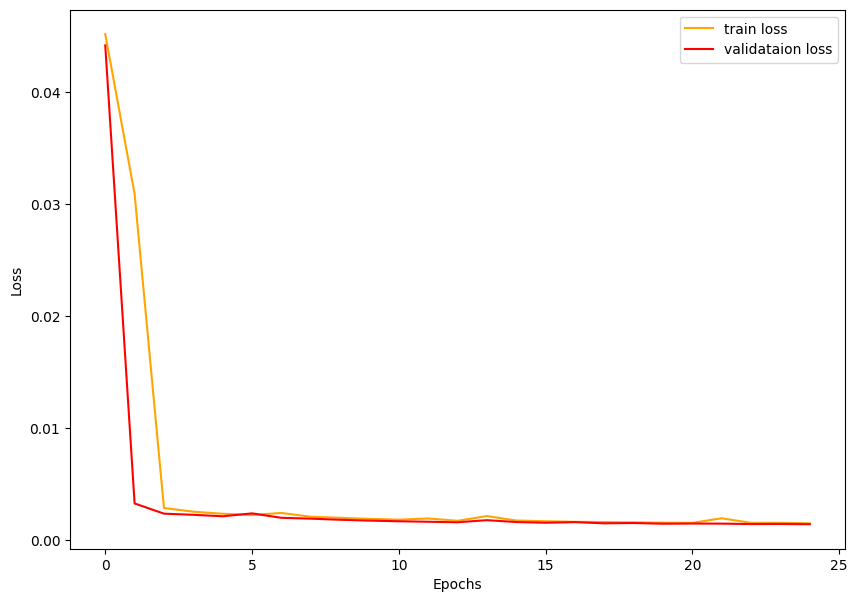

Saving model...


In [10]:
train_loss  = []
val_loss = []
start = time.time()
for epoch in range(25):
    print(f"Epoch {epoch+1} of {25}")
    train_epoch_loss = fit(model, trainloader, epoch)
    val_epoch_loss = validate(model, valloader, epoch)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    scheduler.step(val_epoch_loss)
end = time.time()

print(f"Took {((start-end)/60):.3f} minutes to train")

# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('drive/My Drive/Image-Deblurring/outputs/loss.png')
plt.show()

# save the model to disk
print('Saving model...')
torch.save(model.state_dict(), 'drive/My Drive/Image-Deblurring/outputs/model.pth')

In [11]:
!nvidia-smi

Fri Feb 23 21:38:10 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0              34W /  70W |    459MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--